# Import Libraries

In [1]:
import numpy as np
import torch

from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''

x = np.linspace(0, np.pi, 256)

x_test = x.reshape(x.shape[0],1)
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([1,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
print(PINN)

/home/admin_user/.pyenv/versions/3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
test dataset: (256, 1) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=200, \
    lb=[0], ub=[np.pi], steps=2, eps=2e-1, eta=2e-2, m=0):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-(m+1)*n_samples:,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, x_train, x_adv, x_boundary, u_boundary, x_test, epoch=2e4):
    
    x_train_temp = np.vstack([x_train, x_adv])
    
    f_test_pred = np.abs(model.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(x_test, f_test_pred, title="test $r(x;theta)$", ylim=[-1,3])
    print('Test residual MSE: %.5f'  % (np.mean(np.square(f_test_pred))))

    model.iter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.train_model_adam(optimizer, x_boundary, u_boundary, x_train_temp, epoch)
    
    u_pred = model(x_test).squeeze().cpu().detach().numpy()
    
    plot_u(x_test, u_pred)

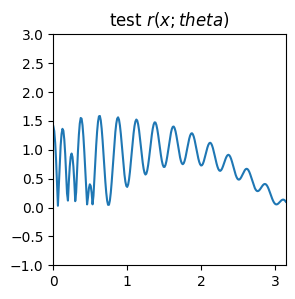

Test residual MSE: 0.79493
1000 tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.4626, device='cuda:0', grad_fn=<AddBa

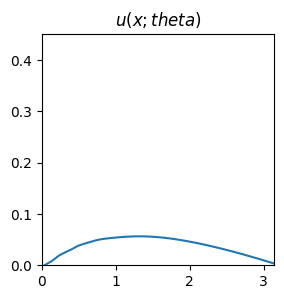

In [3]:
''' k=0 '''
N0 = 200
x_train, x_boundary, u_boundary = training_data_latin_hypercube(x, N_inner=N0)
retrain(PINN, x_train, np.array([]).reshape((0,1)), x_boundary, u_boundary, x_test, epoch=3e4)

k= 0


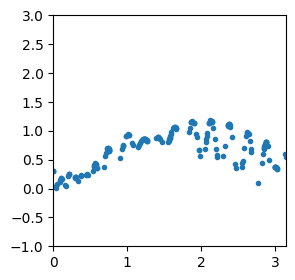

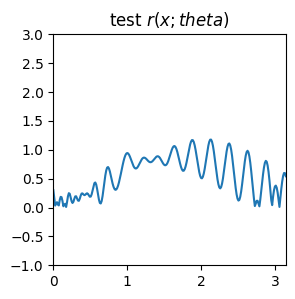

Test residual MSE: 0.43109
1000 tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.4552, device='cuda:0', grad_fn=<AddBa

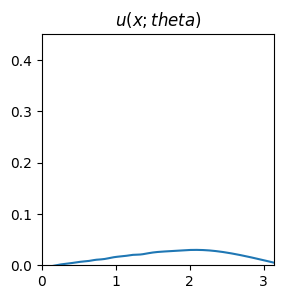

k= 1


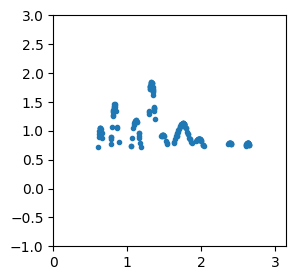

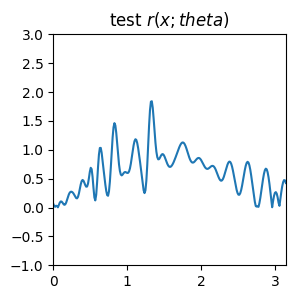

Test residual MSE: 0.50320
1000 tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.4789, device='cuda:0', grad_fn=<AddBa

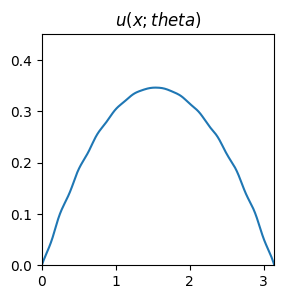

k= 2


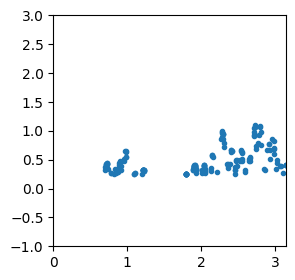

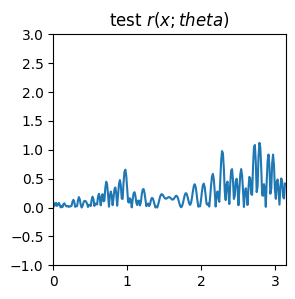

Test residual MSE: 0.11320
1000 tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0492, device='cuda:0', grad_fn=<AddBa

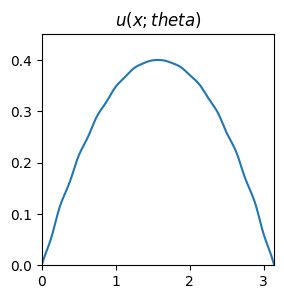

k= 3


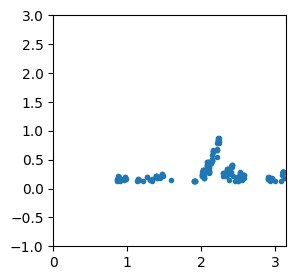

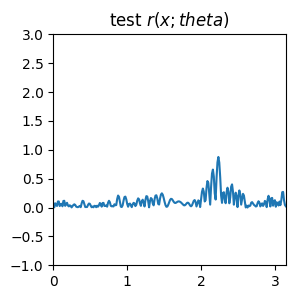

Test residual MSE: 0.03053
1000 tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0238, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0222, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0185, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0130, device='cuda:0', grad_fn=<AddBa

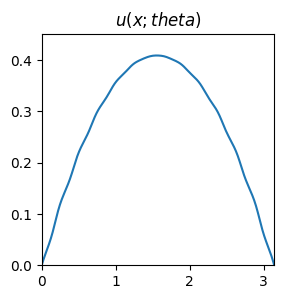

k= 4


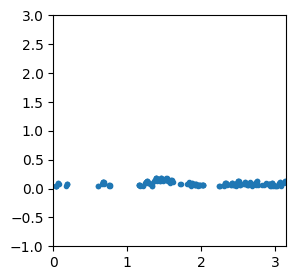

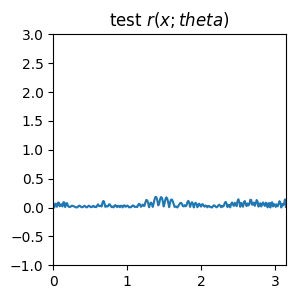

Test residual MSE: 0.00396
1000 tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0036, device='cuda:0', grad_fn=<AddBa

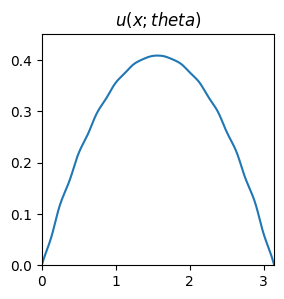

k= 5


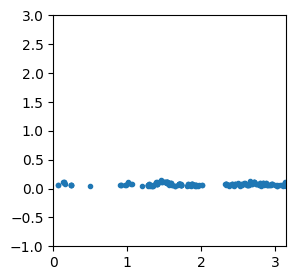

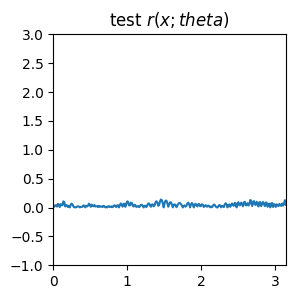

Test residual MSE: 0.00275
1000 tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0028, device='cuda:0', grad_fn=<AddBa

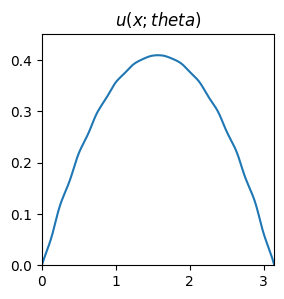

k= 6


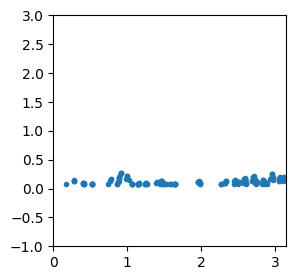

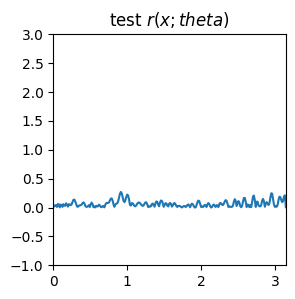

Test residual MSE: 0.00708
1000 tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0023, device='cuda:0', grad_fn=<AddBa

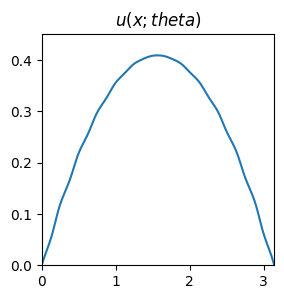

k= 7


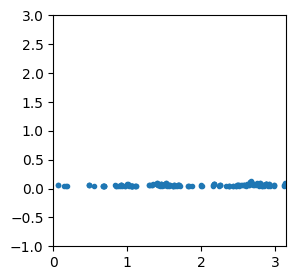

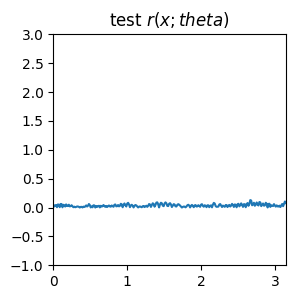

Test residual MSE: 0.00184
1000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0019, device='cuda:0', grad_fn=<AddBa

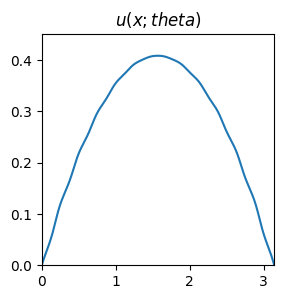

k= 8


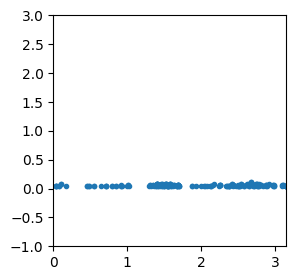

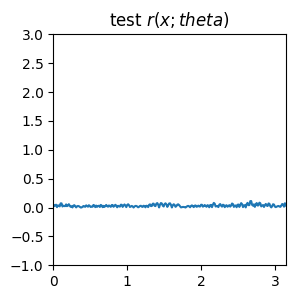

Test residual MSE: 0.00149
1000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0014, device='cuda:0', grad_fn=<AddBa

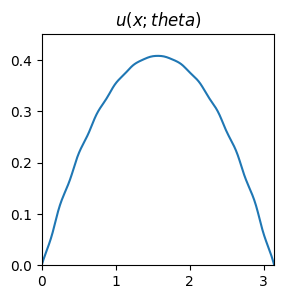

k= 9


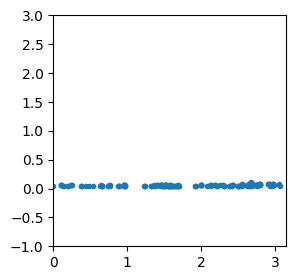

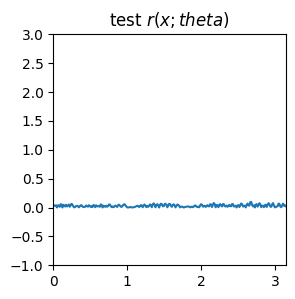

Test residual MSE: 0.00132
1000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0012, device='cuda:0', grad_fn=<AddBa

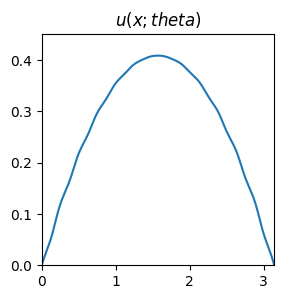

k= 10


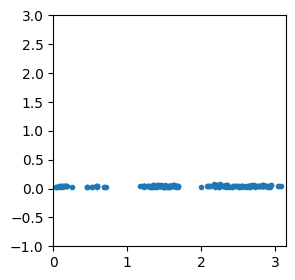

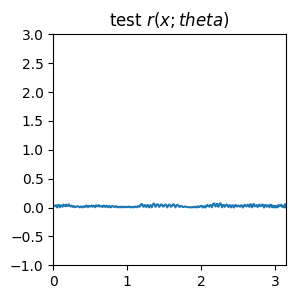

Test residual MSE: 0.00095
1000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0014, device='cuda:0', grad_fn=<AddBa

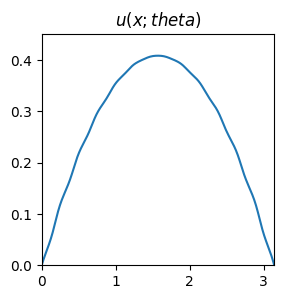

k= 11


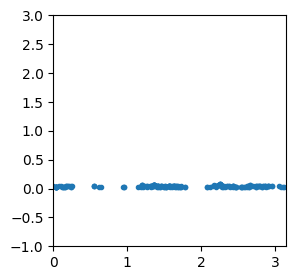

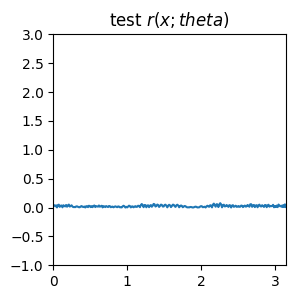

Test residual MSE: 0.00082
1000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0009, device='cuda:0', grad_fn=<AddBa

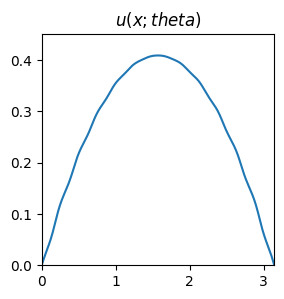

k= 12


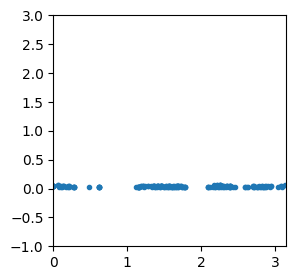

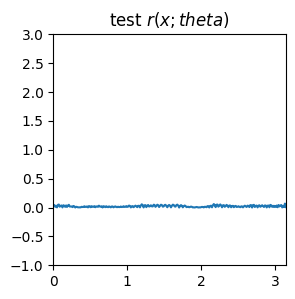

Test residual MSE: 0.00069
1000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0010, device='cuda:0', grad_fn=<AddBa

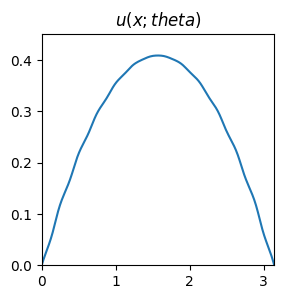

k= 13


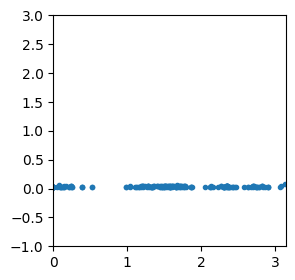

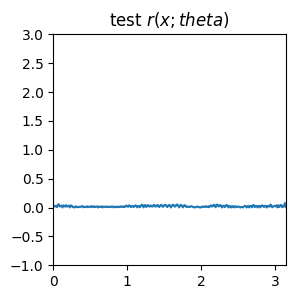

Test residual MSE: 0.00063
1000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0013, device='cuda:0', grad_fn=<AddBa

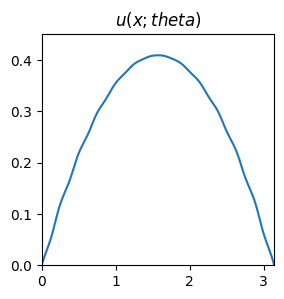

k= 14


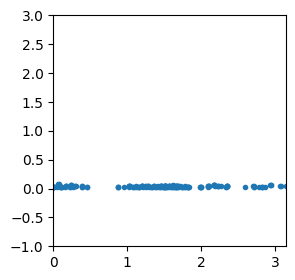

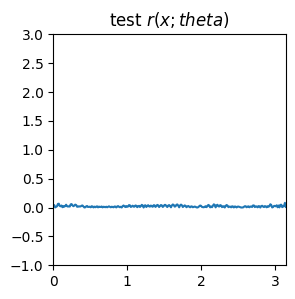

Test residual MSE: 0.00068
1000 tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0019, device='cuda:0', grad_fn=<AddBa

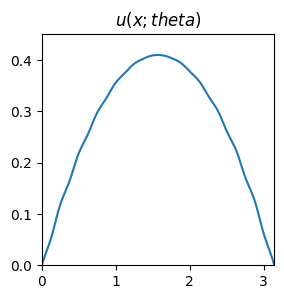

k= 15


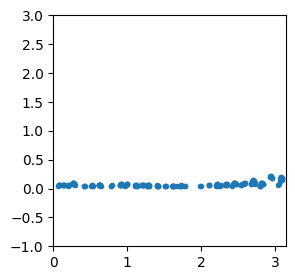

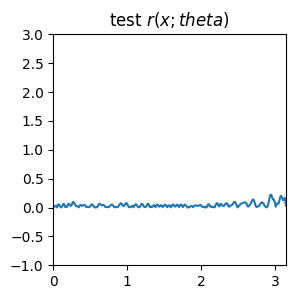

Test residual MSE: 0.00335
1000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0047, device='cuda:0', grad_fn=<AddBa

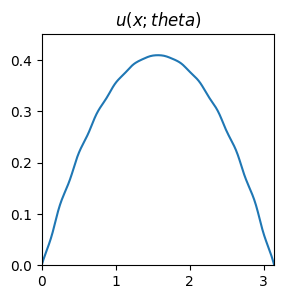

k= 16


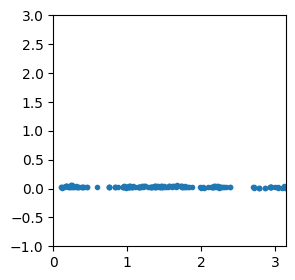

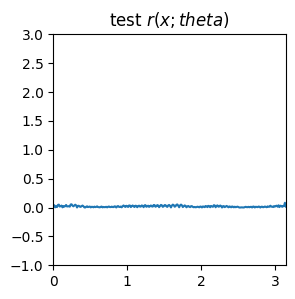

Test residual MSE: 0.00054
1000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0013, device='cuda:0', grad_fn=<AddBa

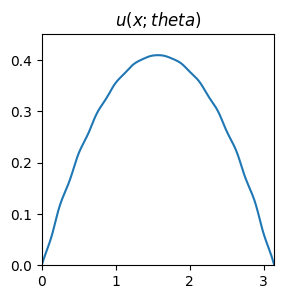

k= 17


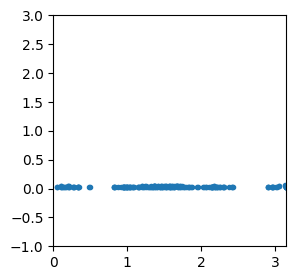

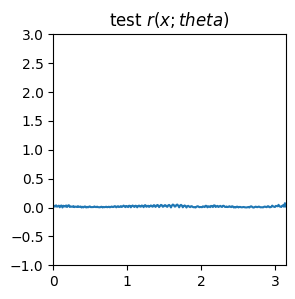

Test residual MSE: 0.00047
1000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0007, device='cuda:0', grad_fn=<AddBa

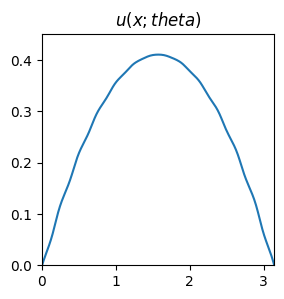

k= 18


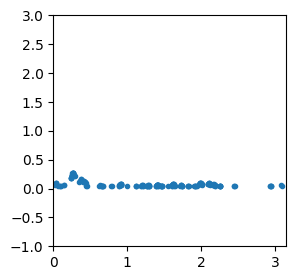

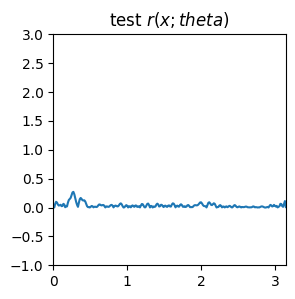

Test residual MSE: 0.00305
1000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0006, device='cuda:0', grad_fn=<AddBa

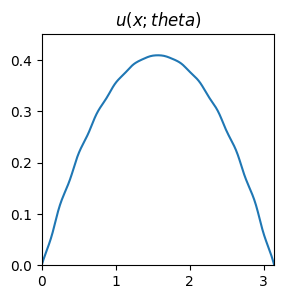

k= 19


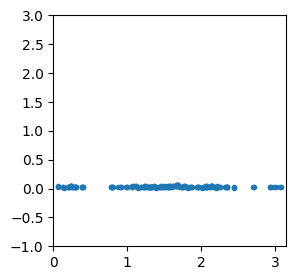

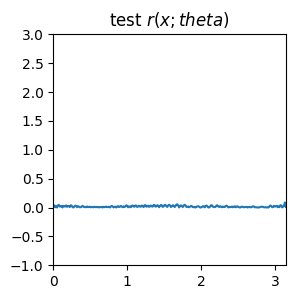

Test residual MSE: 0.00049
1000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0012, device='cuda:0', grad_fn=<AddBa

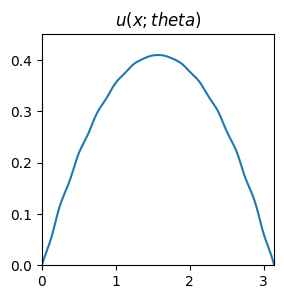

k= 20


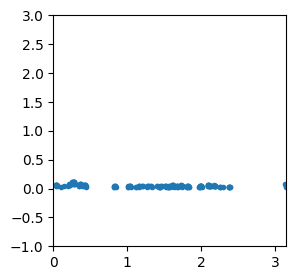

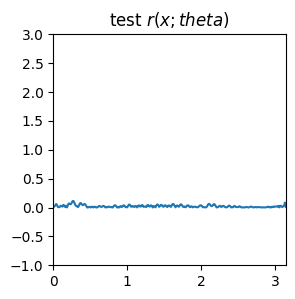

Test residual MSE: 0.00087
1000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0008, device='cuda:0', grad_fn=<AddBa

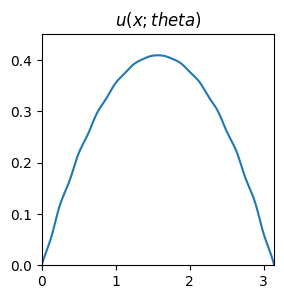

k= 21


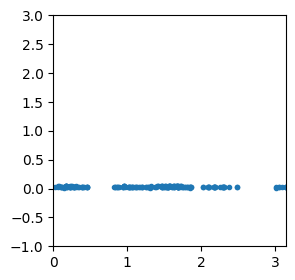

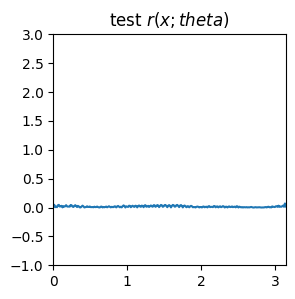

Test residual MSE: 0.00042
1000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0012, device='cuda:0', grad_fn=<AddBa

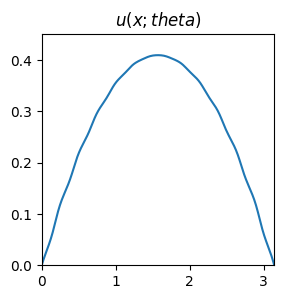

k= 22


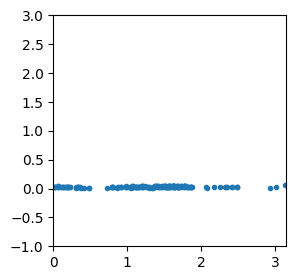

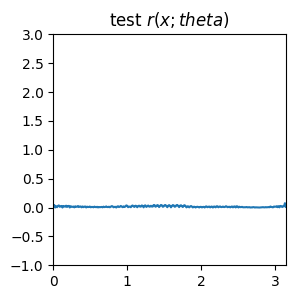

Test residual MSE: 0.00038
1000 tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0005, device='cuda:0', grad_fn=<AddBa

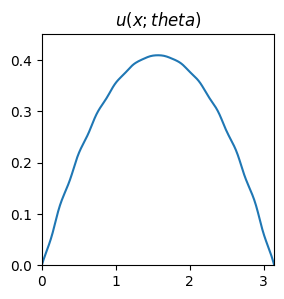

k= 23


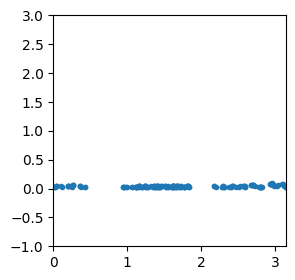

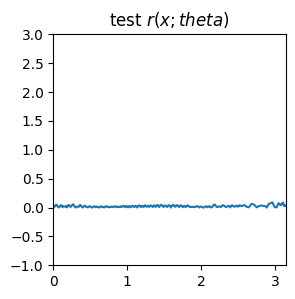

Test residual MSE: 0.00083
1000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0008, device='cuda:0', grad_fn=<AddBa

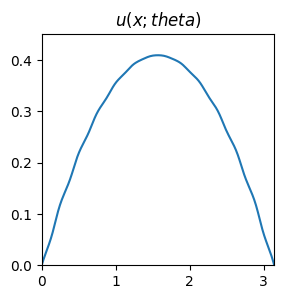

k= 24


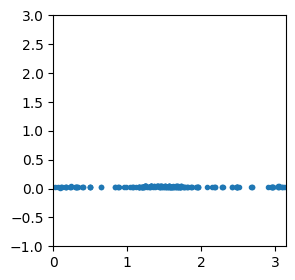

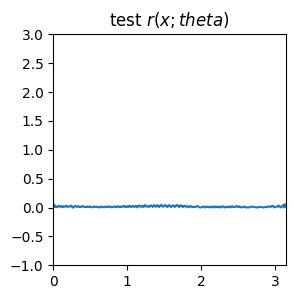

Test residual MSE: 0.00037
1000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0005, device='cuda:0', grad_fn=<AddBa

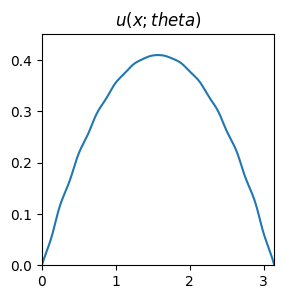

k= 25


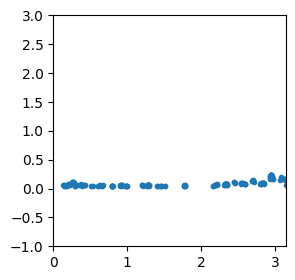

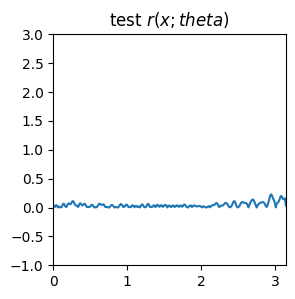

Test residual MSE: 0.00361
1000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0005, device='cuda:0', grad_fn=<AddBa

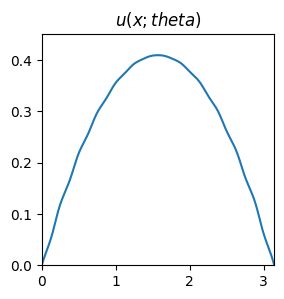

k= 26


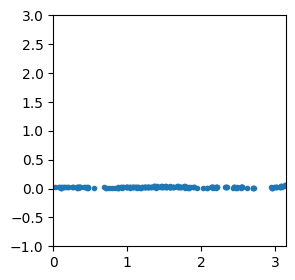

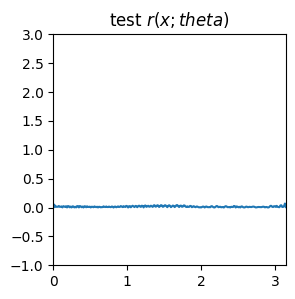

Test residual MSE: 0.00036
1000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0005, device='cuda:0', grad_fn=<AddBa

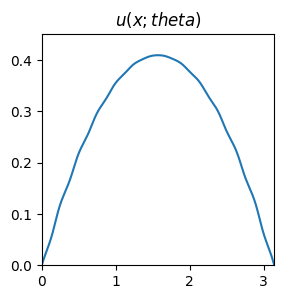

k= 27


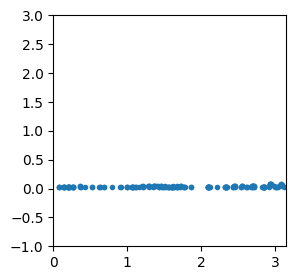

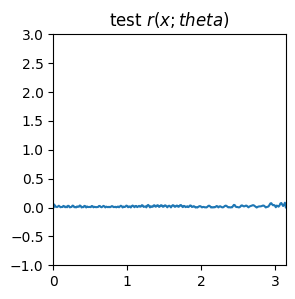

Test residual MSE: 0.00060
1000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0006, device='cuda:0', grad_fn=<AddBa

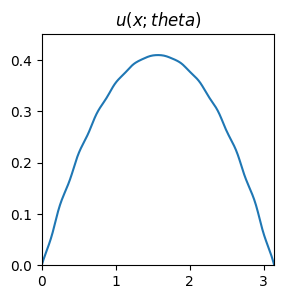

k= 28


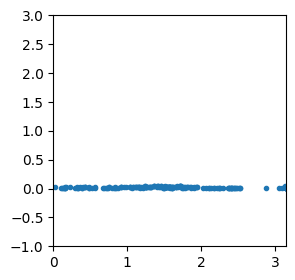

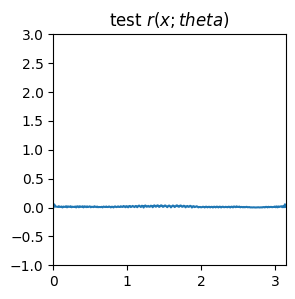

Test residual MSE: 0.00029
1000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0008, device='cuda:0', grad_fn=<AddBa

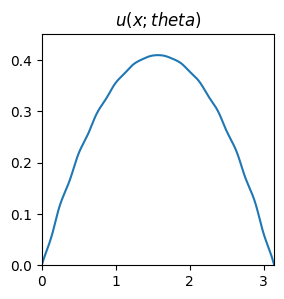

k= 29


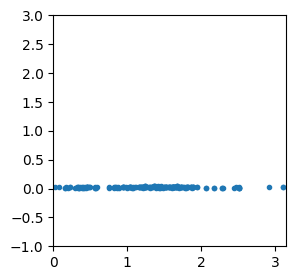

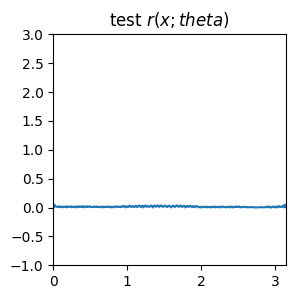

Test residual MSE: 0.00029
1000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0004, device='cuda:0', grad_fn=<AddBa

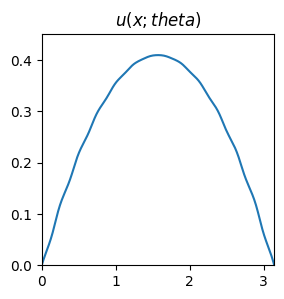

In [4]:
x_adv = np.array([]).reshape((0,1))
''' k=1:30 '''
for i in range(30):
    print("k=", i)
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, epoch=3e4)

k= 30


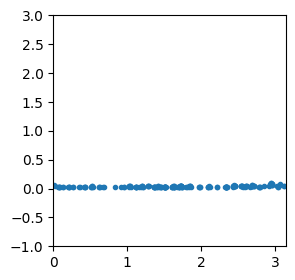

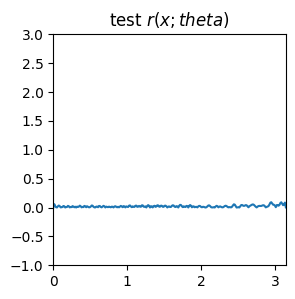

Test residual MSE: 0.00072
1000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0003, device='cuda:0', grad_fn=<AddBa

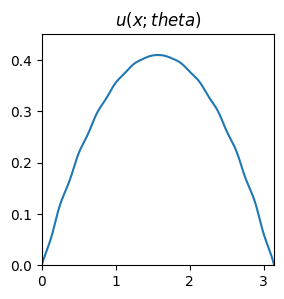

k= 31


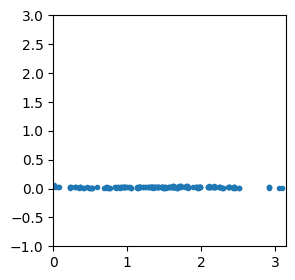

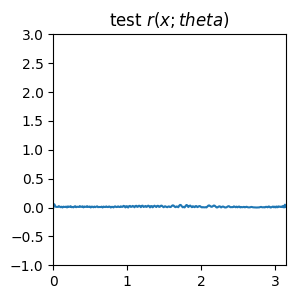

Test residual MSE: 0.00030
1000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0003, device='cuda:0', grad_fn=<AddBa

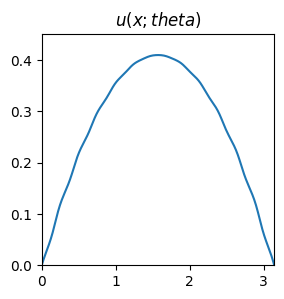

k= 32


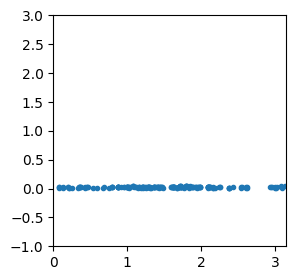

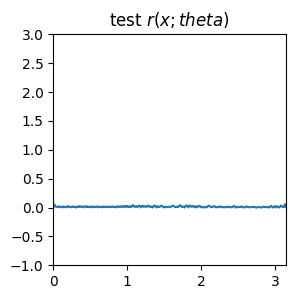

Test residual MSE: 0.00028
1000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0005, device='cuda:0', grad_fn=<AddBa

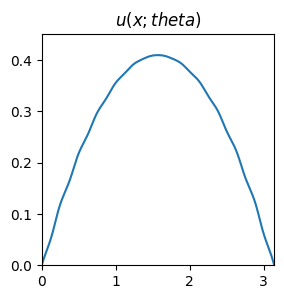

k= 33


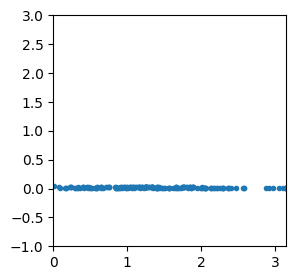

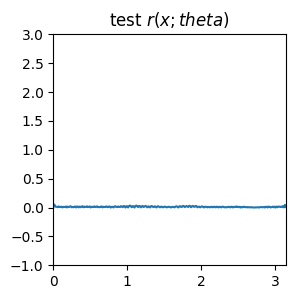

Test residual MSE: 0.00021
1000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0015, device='cuda:0', grad_fn=<AddBa

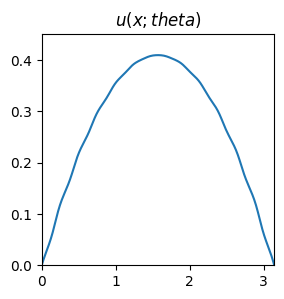

k= 34


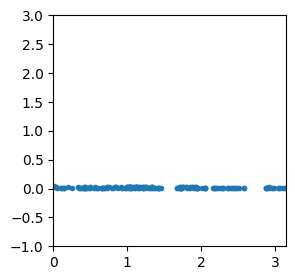

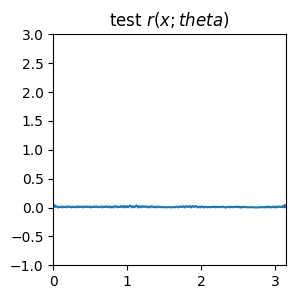

Test residual MSE: 0.00019
1000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0002, device='cuda:0', grad_fn=<AddBa

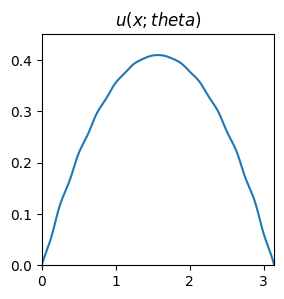

In [5]:
for i in range(5):
    print("k=", i+30)
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, epoch=3e4)